**PROGRAMA CON EL QUE SE PUEDEN ENTRENAR LOS MODELOS XY & mhe POR IGUAL**


1.   Desde MATLAB se importa directamente las matrices y tablas escaladas
2.   2000x8 en la red -> todos los sensores dentro pero manteniendo la filosofía de red
3.   Multiple target: x, y.

**RESULTADOS**

Error absoluto acumulado

*   Training loss: 0.0850 || X: 32.7501 || Y: 29.1877



# **PARAMETERS**

In [ ]:
study = 'XY'
# study = 'mhe'
k = 4
load_model = False      # If = 1 --> pretrained model will be loaded, else, no
path = r'/content/drive/MyDrive/MUSE/S4/Andres/DS_Features.pkl'
k = 1
target = [0, 1]
Nlabels = 5
batch_size = 32
saveit = False

# **IMPORTS**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from __future__ import print_function, division
torch.manual_seed(0)
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline

import time


##
import scipy.io
import numpy as np
import os
import pandas as pd
import h5py
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

##
!pip3 install pickle5
import pickle5 as pickle 

cuda


# **UTILS**

### *Dataset loader*

In [ ]:
def f_Get_Impact_Database_XY( path ):
    """
    Load .mat file and extract fields
    Args:
        data_dir (strign): Path to X.mat and Y.csv (also contains Y.mat).
    Return:
        X (dataframe): X matrix converted to dataframe, more easy to process data with df.
        Y (dataframe): multiple targets.
    """
    # Rerad pickle
    with open(path, 'rb') as inp:
        dataset = pickle.load(inp)
    # Extract data and labels
    X = np.array(dataset["X"])
    X = np.delete(X, 6, 1)      # Column 6 is all 0
    Y = np.array(dataset["Y"])  # 0 = Temp, 1 = Strain

    # Normalize X
    for i in range(X.shape[1]):
        min = np.min(X[:,i])
        max = np.max(X[:,i])
        X[:,i] = (X[:,i] - min)/(max - min)
    # Normalize Y
    for i in range(Y.shape[1]):
        min = np.min(Y[:,i])
        max = np.max(Y[:,i])
        Y[:,i] = (Y[:,i] - min)/(max - min)


    ## Split
    test_per = 0.6
    train_per = 0.2
    val_per = 0.2

    if np.round(test_per + train_per + val_per, 3) != 1.0:
        print( "Train, test and validation percentajes don't sum 1" )
    
    # Array with idxs
    idx_compleate = np.linspace( 0, X.shape[0]-1, X.shape[0] )

    # Generate training index
    idx_train, idx_tv = train_test_split(
        idx_compleate, 
        test_size=(1-train_per),
        random_state=1
    )
    # Generate test and validation index
    idx_val, idx_test = train_test_split(
        idx_tv, 
        test_size = test_per/(test_per+val_per),
        random_state=1
    )

    idx_train = idx_train.astype(int)
    idx_val = idx_val.astype(int)
    idx_test = idx_test.astype(int)

    Xdict = dict.fromkeys(['train', 'val', 'test'])
    Ydict = dict.fromkeys(['train', 'val', 'test'])

    Xdict['train'] = X[idx_train,:]
    Ydict['train'] = Y[idx_train,:]
    Xdict['val'] = X[idx_val,:]
    Ydict['val'] = Y[idx_val,:]
    Xdict['test'] = X[idx_test,:]
    Ydict['test'] = Y[idx_test,:]

    return Xdict, Ydict


# Dataloader 
class c_Impacts_Dataset(Dataset):
    """Impacts dataset."""
    def __init__(self, x, y, transform=None):
        self.x = torch.from_numpy( x ).float()
        self.y = torch.from_numpy( y ).float()
        self.N = y.shape[0]
    def __len__(self):
        return self.N
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx,:]

    
# Get Datasets
def f_Get_Dataset(X, Y):
    """
    Load train, val and test dataset into a dictionary
    Args:
        X (dictionary): data.
        Y (dictionary): labels.
        target (list): net targets.
    Return:
        ds (dictionary): dictionary with PyTorch DataSet.
    """
    ds = dict.fromkeys(list(X.keys()))
    for key in ds.keys():
        ds[key] = c_Impacts_Dataset(X[key],Y[key])

    return ds


# Get Datasets
def f_Get_Dataloader(ds, batch_size=32):
    """
    Obtain the dataloaders from the datasets
    Args:
        ds (dictionary): train, val, test datasets.
        batch_size (int): batch size.
    Return:
        dl (dictionary): dictionary with PyTorch DataLoader.
    """
    dl = dict.fromkeys(list(ds.keys()))
    for key in ds.keys():
        dl[key] = DataLoader(dataset=ds[key],batch_size=32,shuffle=True)

    for key in dl.keys():
        print(key)
        for i_batch, sample_batched in enumerate(dl[key]):       
            for i in range(0, 1):
                plt.plot(sample_batched[0][i],linewidth=1)
                plt.title(sample_batched[1][i])
                plt.xlim([0, 15])
                plt.ylim([-0.05, 1.05])
                plt.grid()
                plt.show()
            if i_batch == 2:
                break
    
    return dl


def f_Data_Preparation(path, batch_size):
    # Read dataset
    X, Y = f_Get_Impact_Database_XY( path )

    # Dataset
    ds = f_Get_Dataset(X, Y)

    # Dataloader
    dl = f_Get_Dataloader(ds)

    return ds, dl

### *UTILS PARA USAR XY - mhe*

#### NET

In [ ]:
# Weights initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Compress sensor layer
class First_Stage_Layer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self):
        super().__init__()

        # Layer secuence
        self.FC = nn.Sequential(
            nn.Linear(15, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            # nn.Dropout(p=0.2),
            nn.Linear(100, 250),
            nn.Tanh(),
            # nn.Dropout(p=0.2),
            nn.Linear(250, 500),
            nn.Tanh(),
            # nn.Dropout(p=0.2),
            nn.Linear(500, 1000)          
        ).apply(init_weights)
    def forward(self, x):
        x = self.FC(x)
        return x

class Second_Stage_Layer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self):
        super().__init__()
        # Layer secuence
        self.FC = nn.Sequential(
            nn.Linear(1000, 500),
            nn.Tanh(),
            nn.Linear(500, 250),
            nn.Tanh(),
            nn.Linear(250, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 15),
            nn.Tanh(),
            nn.Linear(15, 1),
            nn.ReLU()
        ).apply(init_weights)
    def forward(self, x):
        x = self.FC(x)
        return x

class TE(nn.Module):
    def __init__(self):
        super(TE, self).__init__()
        self.cs0 = First_Stage_Layer()
        self.fc_T = Second_Stage_Layer()
        self.fc_E = Second_Stage_Layer()
    def forward(self, x):
        bs = x.shape[0]
        x0 = self.cs0(x.reshape(bs,-1))
        
        T = self.fc_T(x0).flatten()
        E = self.fc_E(x0).flatten()
        
        return T, E

#### Training

In [ ]:
def f_Training_TE(model, device, num_epochs, dl):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        loss_sum = 0
        model.train()
        for (x, y) in dl['train']:
            x = x.to(device)
            y = y.to(device)
            # Forward pass
            X, Y = model(x)
            # Losses
            loss_X = criterion(X, y[:,0])
            loss_Y = criterion(Y, y[:,1])
            loss = loss_X + loss_Y
            loss_sum += loss
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        else:
            with torch.no_grad():
                model.eval()
                X_sum = 0
                Y_sum = 0
                for x, y in dl['val']:
                    x = x.to(device)
                    #forward pass
                    X, Y = model(x)
                    # Mean Square Error
                    X_sum += torch.sum( torch.abs( X.to('cpu') - y[:,0].to('cpu') ) )
                    Y_sum += torch.sum( torch.abs( Y.to('cpu') - y[:,1].to('cpu') ) )
                print(f'Epoch: {epoch+1} of {num_epochs} || Training loss: {loss_sum:.4f} || T: {X_sum:.4f} || E: {Y_sum:.4f}')
    return model

# **Data preparation**

train


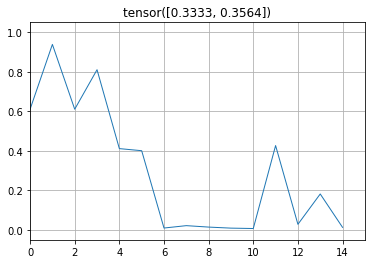

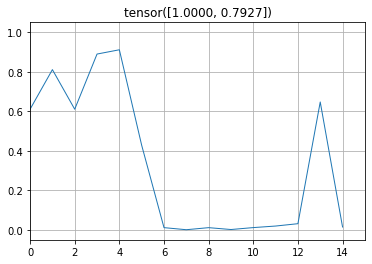

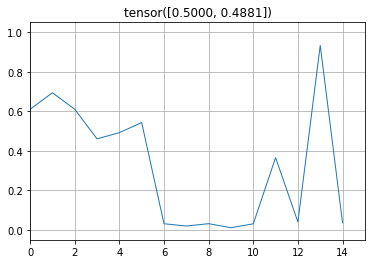

val


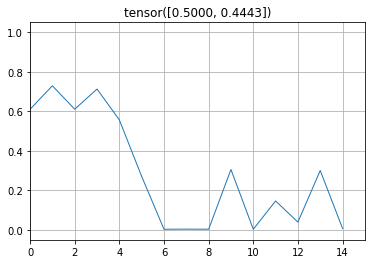

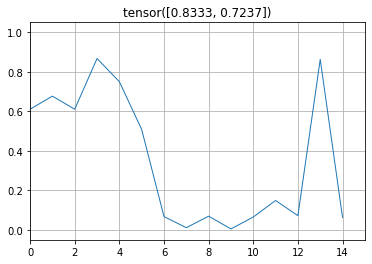

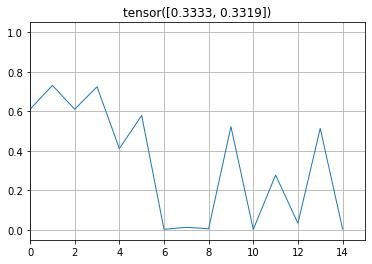

test


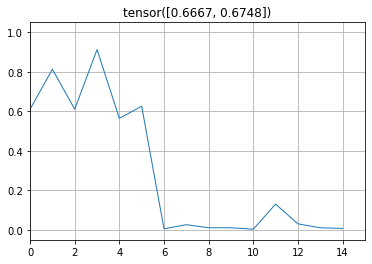

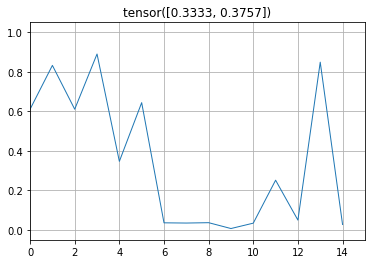

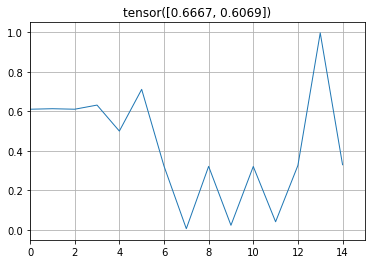

In [ ]:
ds, dl = f_Data_Preparation(path, batch_size)

# **MODEL**

In [ ]:
# MODEL
model = TE().to(device)
if load_model == True:
    model.load_state_dict(
        torch.load('/content/drive/MyDrive/MUSE/S3/CE2/Redes/Multiple_Outputs/XY/Models/XY_model_k-0'+str(k),
                map_location=torch.device(device)
        )
    )    

# **Training**



1.   E = 30, lr = -5
2.   E = 5, lr = -6





In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-5
                             # weight_decay=1e-4
                             )

num_epochs = 100

model = f_Training_TE(model, device, num_epochs, dl)

Epoch: 1 of 100 || Training loss: 0.2580 || T: 353.2570 || E: 437.6760
Epoch: 2 of 100 || Training loss: 0.1981 || T: 352.4630 || E: 435.3460
Epoch: 3 of 100 || Training loss: 0.1777 || T: 351.2863 || E: 434.5766
Epoch: 4 of 100 || Training loss: 0.1631 || T: 351.8425 || E: 434.6490
Epoch: 5 of 100 || Training loss: 0.1530 || T: 351.4307 || E: 435.7031
Epoch: 6 of 100 || Training loss: 0.1452 || T: 352.1277 || E: 435.4885
Epoch: 7 of 100 || Training loss: 0.1379 || T: 352.7153 || E: 436.0013
Epoch: 8 of 100 || Training loss: 0.1331 || T: 351.2285 || E: 435.7890
Epoch: 9 of 100 || Training loss: 0.1286 || T: 351.9449 || E: 435.7666
Epoch: 10 of 100 || Training loss: 0.1247 || T: 350.8260 || E: 435.7359
Epoch: 11 of 100 || Training loss: 0.1224 || T: 352.3551 || E: 435.3745
Epoch: 12 of 100 || Training loss: 0.1187 || T: 352.4842 || E: 436.7713
Epoch: 13 of 100 || Training loss: 0.1157 || T: 353.1620 || E: 438.5775
Epoch: 14 of 100 || Training loss: 0.1134 || T: 353.0700 || E: 437.7857
E

# **SAVE MODEL**

In [ ]:
if saveit:
    torch.save(
        model.state_dict(),
        '/content/drive/MyDrive/MUSE/S3/CE2/Redes/Multiple_Outputs/XY/Models/XY_model_k-0'+str(k)'
    )

# **RESULTS**

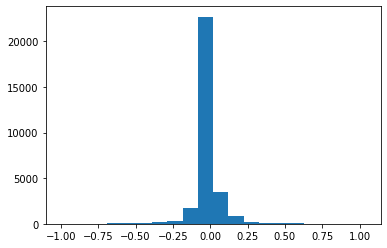

Error absoluto acumulado T: 0.0391


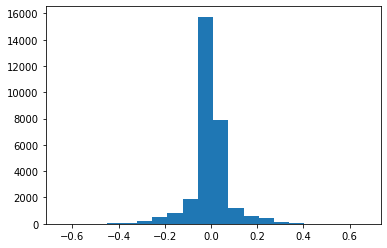

Error absoluto acumulado E: 0.0467


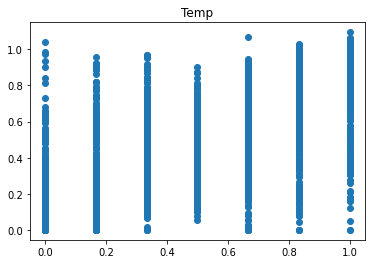

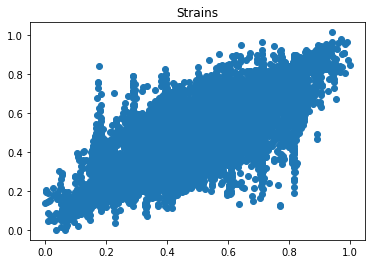

In [ ]:
e_X = np.zeros(len(ds['test']))
e_Y = np.zeros(len(ds['test']))
predT = np.zeros(len(ds['test']))
predE = np.zeros(len(ds['test']))
T = np.zeros(len(ds['test']))
E = np.zeros(len(ds['test']))
X_ae = 0
Y_ae = 0

with torch.no_grad():
    model.eval()
    for i in range(0,len(ds['test'])):
        # Extract the sample
        x, y = ds['test'][i]
        y = y.to('cpu').detach().numpy()
        # Inference
        X, Y = model(x.reshape([1,-1]).to(device))
        X, Y = X.to('cpu').detach().numpy(), Y.to('cpu').detach().numpy()
        # Error
        
        predT[i] = X
        predE[i] = Y
        T[i] = y[0]
        E[i] = y[1]
        e_X[i] = X - y[0]
        e_Y[i] = Y - y[1]

plt.hist(e_X, bins=20)
plt.show()
print(f'Error absoluto acumulado T: {sum(abs(e_X))/len(e_X):.4f}')
plt.hist(e_Y, bins=20)
plt.show()
print(f'Error absoluto acumulado E: {sum(abs(e_Y))/len(e_Y):.4f}')

plt.scatter(T, predT)
plt.title('Temp')
plt.show()
plt.scatter(E, predE)
plt.title('Strains')
plt.show()